# Solvent Small Experiment

Question: Could be use data from minotiry solvents? Does it add value/relevant information?

Descriptions:
- 3 solvent availables, one majority and two minorities
- sample from majority and minorities: 3 samples
- train in majority
- evaluate in 3 samples and compare results, is there any particular improvement in majority?

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from src.config import chemical_inventory_path, raw_data_path
from src.data import notebook_utils as utils
from src.constants import GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY, \
                        INCHI_TO_CHEMNAME, TARGET_COL, RXN_FEAT_NAME, ORGANOAMONIUM_INCHI_KEY_COL
from src import plot_utils

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.reload_library()
import matplotlib.patches as mpatches

In [157]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
import sklearn.ensemble as ensamble_models
import sklearn.neighbors as neighbors_models
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as linear_models
from sklearn.metrics import matthews_corrcoef, make_scorer

In [3]:
%cd ../..

/Users/mticona/Documents/tesis/licentiate-thesis-repo


## Models definitions

In [186]:
def make_model(model_name, model_config={}):
    try:
        model_method = getattr(neighbors_models, model_name)
    except AttributeError: 
        try:
            model_method = getattr(ensamble_models, model_name)
        except AttributeError:
            model_method = getattr(linear_models, model_name)
    
    model = model_method(**model_config)
    return model

def split_X_y(df):
    X = df.drop([TARGET_COL], axis=1).values
    y = df[TARGET_COL].values
    return X, y

def proof_concept(model_name, df_train, df_test, model_config = {}):
    model = make_model(model_name, model_config)
    
    X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    
    pipeline.fit(X_train, y_train)
    
    y_pred =  pipeline.predict(X_test)
    
    matt = matthews_corrcoef(y_test, y_pred)
    
    report = classification_report(y_test, y_pred, labels=[0,1], 
                                   output_dict=True, target_names=["No cristaliza", "Cristaliza"])
    
    report_df =  pd.DataFrame(report).transpose()
    
    report_df["matthew"] = matt
    
    return report_df

def proof_concept_model(model_name, df_train, df_test, model_config = {}):
    model = make_model(model_name, model_config)
    
    X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    
    pipeline = Pipeline(steps=pipeline_steps)
    
    pipeline.fit(X_train, y_train)
    
    return pipeline
    
def full_pipeline(model_name, df_train, df_test, k_fold_config, model_config):
    
    model = make_model(model_name, model_config)
    
    #X_test, y_test = split_X_y(df_test)
    X_train, y_train = split_X_y(df_train)
    
    pipeline_steps = [('std', StandardScaler()), 
                      ('model', model)
                     ]
    pipeline = Pipeline(steps=pipeline_steps)
    
    cv = RepeatedStratifiedKFold(**k_fold_config)
    
    
    scores = cross_validate(pipeline, X_train, y_train, cv=cv,
                         scoring={'recall': 'recall', 
                                  'f1': 'f1',
                                  'precision': 'precision',
                                  'matthew': make_scorer(matthews_corrcoef)},
                         return_train_score=True)
    
    return scores

## Read datasets

In [57]:
solvents_inchies = [GBL_INCHI_KEY, DMSO_INCHI_KEY, DMF_INCHI_KEY]
solvents = [INCHI_TO_CHEMNAME[inchie] for inchie in solvents_inchies]

plot_solvents = {'Gamma-Butyrolactone': "GBL",
                 'Dimethyl sulfoxide':"DMSO",
                 'Dimethylformamide': "DMF"}

df_full_dummies = pd.read_csv("data/all_solvent_cleaned_data.csv")

In [58]:
solvents_data = {INCHI_TO_CHEMNAME[solvent_inchie]: utils.read_data(raw_data_path, organic_key=True,\
                                                                    solvent=solvent_inchie) \
                                                                    .drop_duplicates()
                 for solvent_inchie in solvents_inchies}

/Users/mticona/Documents/tesis/licentiate-thesis-repo/src/data/notebook_utils.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col] = (df[TARGET_COL] == 4).astype(int)


In [59]:
df_by_solvent = {solvent: df_full_dummies.query('solvent == @solvent')
                        for solvent in solvents
                        }

In [60]:
def regenerate_sample(original_sample_dict, target_sample_dict):
    "To filter data points from target that are in original sample"
    new_sampling = {}
    for solvent, data in original_sample_dict.items():
        # df1 contains more data points than df2
        df1 = target_sample_dict[solvent].drop(['solvent_Dimethyl sulfoxide',
       'solvent_Dimethylformamide', 'solvent_Gamma-Butyrolactone', 'solvent'], axis=1)
        df2 = original_sample_dict[solvent]
        keys = list(df1.columns.values)
        i1 = df1.set_index(keys).index
        i2 = df2.set_index(keys).index
        new_sampling[solvent] = target_sample_dict[solvent][i1.isin(i2)]
    return new_sampling

In [132]:
SEED = 201

In [188]:
models = {
    'knn':'KNeighborsClassifier',
    'rf':'RandomForestClassifier',
    'gbc':'GradientBoostingClassifier'
}

n_repeat_k_fold = 25
k_splits = 3

k_fold_config = {
    'random_state': SEED,
    'n_repeats': n_repeat_k_fold,
    'n_splits': k_splits,
}
model_config_rf = {
    'min_samples_split': 4,
    'min_samples_leaf': 3,
    #'class_weight': "balanced_subsample"    
}

model_configs = {
    'knn': {},
    'rf': model_config_rf,
    'gbc': {}
}

Repeat experiments based on SEEDS

In [190]:
DEBUG = False

for SEED in range(0,50):
    model_config_rf['random_state'] = SEED
    if DEBUG:
        print("Running with sample seed: %s\n" % SEED)
    # generate samples from dataset grouped by amine and target
    solvent_data_eval_sample = { solvent: data.groupby([TARGET_COL, ORGANOAMONIUM_INCHI_KEY_COL])\
                                .sample(frac=0.2, random_state=SEED)\
                                .drop([ORGANOAMONIUM_INCHI_KEY_COL], axis=1) \
                                for solvent, data in solvents_data.items()}

    solvent_data_remain_sample = { solvent: data.loc[~data.index\
                                                     .isin(solvent_data_eval_sample[solvent].index)]\
                                for solvent, data in solvents_data.items()}

    df_solvent_samples_test = regenerate_sample(original_sample_dict=solvent_data_eval_sample,
                                                target_sample_dict=df_by_solvent)

    df_solvent_samples_train = { solvent: data.loc[~data.index\
                                                     .isin(df_solvent_samples_test[solvent].index)]\
                                for solvent, data in df_by_solvent.items()}

    if DEBUG:
        print("Testing data:")
        for olvent, data in df_solvent_samples_test.items():
            print(solvent, len(data))

        print("\nTraininig data:")    
        for solvent, data in df_solvent_samples_train.items():
            print(solvent, len(data))

    #########################3### generate evaluation sets ##########

    EVAL_MULTISOLVENT = pd.concat([data for solvent, data in df_solvent_samples_test.items()], axis=0)

    #EVAL_MULTISOLVENT.to_csv("data/solvent-experiment/encoded-solvent-eval-multisolvent_%s.csv" % SEED, index=None)

    # generate encoded solvent train dataset
    df_solvent_full_train = pd.concat([data for solvent, data in df_solvent_samples_train.items()],
                                      axis=0).reset_index(drop=True)

    df_solvent_full_train.to_csv("data/solvent-experiment/encoded-solvent-training_%s.csv" % \
                                 (SEED),
                                 index=None)

    df_solvent_full_train = pd.read_csv("data/solvent-experiment/encoded-solvent-training_%s.csv" % \
                                 (SEED))

    ################################ run experiments ###################


    # Experiments 1
    # test in a MULTISOLVENT sample (encoded)
    # test in same sample but without encoded solvent feature
    def exp_drop_solvent(model_name, df_train, df_test, model_config = {}):
        drop_cols = ['solvent_Dimethyl sulfoxide', 
                     'solvent_Dimethylformamide',
                     'solvent_Gamma-Butyrolactone']
        df_train = df_train.drop(drop_cols, axis=1)
        df_test = df_test.drop(drop_cols, axis=1)
        return proof_concept(model_name, df_train, df_test, model_config)

    ALGORITHMS = ['rf']

    results_dir = "results/solvent_exp_1/"

    model_EVAL_MULTISOLVENT = EVAL_MULTISOLVENT.drop(['solvent'], axis=1)

    model_df_solvent_full_train = df_solvent_full_train.drop(['solvent'], axis=1)


    for ALGORITH in ALGORITHMS:
        results_multisv = proof_concept(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT,
                                            model_configs[ALGORITHM])

        results_no_sv = exp_drop_solvent(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT,
                                            model_configs[ALGORITHM])

        results_multisv.to_csv(results_dir+"eval_multisolvente_encoded_%s_%s.csv" % (SEED, ALGORITH), index=None)

        results_no_sv.to_csv(results_dir+"eval_no_solvent_%s_%s.csv" % (SEED, ALGORITH), index=None)
        
            
    # Experimento 2
    dir_results = "results/solvent_exp_2/"

    for solvent in solvents:
        drop_cols = ['solvent_Dimethyl sulfoxide', 
                     'solvent_Dimethylformamide',
                     'solvent_Gamma-Butyrolactone',
                    'solvent']

        df_train_sv = df_solvent_full_train[df_solvent_full_train.solvent == solvent].drop(drop_cols, axis=1)

        df_test_sv = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop(drop_cols, axis=1)

        df_test_sv_encoded = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop('solvent', axis=1)
        df_train_sv_encoded = df_solvent_full_train.drop('solvent', axis=1)

        # modelo específico por solvente
        report_sv = proof_concept(models[ALGORITHM], df_train_sv, df_test_sv,
                                  model_configs[ALGORITHM])


        # misma muestra en modelo multisolvente
        report_multisv = proof_concept(models[ALGORITHM], df_train_sv_encoded, df_test_sv_encoded,
                                       model_configs[ALGORITHM])


        report_sv.to_csv(dir_results+'model_per_solv_%s_%s.csv' % (SEED, solvent), index=None)
        report_multisv.to_csv(dir_results+'sample_%s_%s_in_multisolvent.csv' % (SEED, solvent), index=None)
        
    if DEBUG:
        print("Done experiment %s\n" % SEED)
    

/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mticona/.local/share/virtualenvs/licentiate-thesis-repo-_Hfi4eev/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

In [ ]:
        
    # Experimento 2
    dir_results = "results/solvent_exp_2/"

    for solvent in solvents:
        drop_cols = ['solvent_Dimethyl sulfoxide', 
                     'solvent_Dimethylformamide',
                     'solvent_Gamma-Butyrolactone',
                    'solvent']

        df_train_sv = df_solvent_full_train[df_solvent_full_train.solvent == solvent].drop(drop_cols, axis=1)

        df_test_sv = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop(drop_cols, axis=1)

        df_test_sv_encoded = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop('solvent', axis=1)
        df_train_sv_encoded = df_solvent_full_train.drop('solvent', axis=1)

        # modelo específico por solvente
        report_sv = proof_concept(models[ALGORITHM], df_train_sv, df_test_sv,
                                  model_configs[ALGORITHM])


        # misma muestra en modelo multisolvente
        report_multisv = proof_concept(models[ALGORITHM], df_train_sv_encoded, df_test_sv_encoded,
                                       model_configs[ALGORITHM])


        report_sv.to_csv(dir_results+'model_per_solv_%s_%s.csv' % (SEED, solvent), index=None)
        report_multisv.to_csv(dir_results+'sample_%s_%s_in_multisolvent.csv' % (SEED, solvent), index=None)
        
    if DEBUG:
        print("Done experiment %s\n" % SEED)

In [167]:
# Experiments 1
# test in a MULTISOLVENT sample (encoded)
# test in same sample but without encoded solvent feature
def exp_drop_solvent(model_name, df_train, df_test, k_fold_config, model_config = {}):
    drop_cols = ['solvent_Dimethyl sulfoxide', 
                 'solvent_Dimethylformamide',
                 'solvent_Gamma-Butyrolactone']
    df_train = df_train.drop(drop_cols, axis=1)
    df_test = df_test.drop(drop_cols, axis=1)
    #return proof_concept(model_name, df_train, df_test, model_config)
    return full_pipeline(model_name, df_train, df_test, k_fold_config, model_config)

ALGORITHMS = ['rf']

results_dir = "solvent_exp_1_crossval"

model_EVAL_MULTISOLVENT = EVAL_MULTISOLVENT.drop(['solvent'], axis=1)

model_df_solvent_full_train = df_solvent_full_train.drop(['solvent'], axis=1)


for ALGORITH in ALGORITHMS:
    results_experiment_1 = full_pipeline(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT, k_fold_config,
                                        model_configs[ALGORITHM])

    results_experiment_s_sv = exp_drop_solvent(models[ALGORITHM], model_df_solvent_full_train, model_EVAL_MULTISOLVENT, k_fold_config,
                                        model_configs[ALGORITHM])

    report_multisv =  pd.DataFrame(results_experiment_1)
    report_no_sol =  pd.DataFrame(results_experiment_s_sv)    


In [172]:
def exp_2_boxplot(df):
    #with plt.style.context(['science', 'bright']):
    g = sns.catplot(x="Métrica", y="Score",
                hue="Exp", col='sv', col_wrap=3, height=3, aspect=1.2,
                #col_order=["Cristaliza", "No cristaliza"], 
                    #palette=[bright.red, bright.grey],
                kind='box', sharey=True, sharex=True, data=df, legend=True)


<AxesSubplot:>

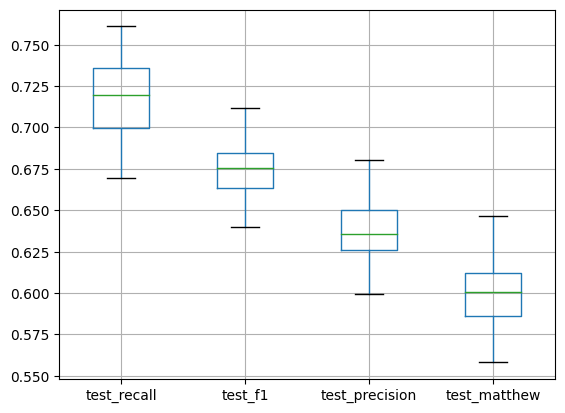

In [177]:
test_cols = [col for col in report_multisv.columns if col.startswith("test")]

report_multisv[test_cols].boxplot(column=test_cols)  

<AxesSubplot:>

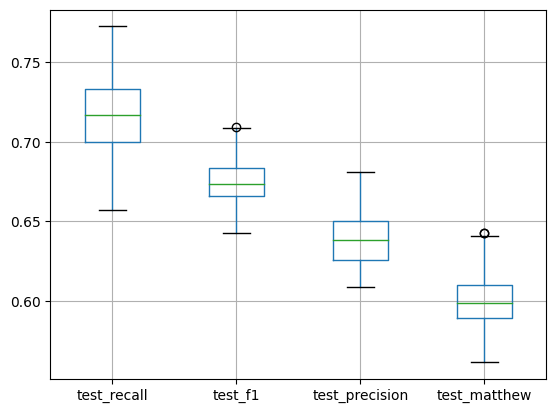

In [178]:
report_no_sol[test_cols].boxplot(column=test_cols)  

In [184]:
results_dir = "results/solvent_exp_1_crossval/"

report_multisv.to_csv(results_dir+"eval_multisolvente_encoded_%s_%s.csv" % (SEED, ALGORITH), index=None)

report_no_sol.to_csv(results_dir+"eval_no_solvent_%s_%s.csv" % (SEED, ALGORITH), index=None)

In [139]:
report_multisv.transpose()

,No cristaliza,Cristaliza,accuracy,macro avg,weighted avg
precision,0.935294,0.650000,0.880952,0.792647,0.885028
recall,0.919075,0.702703,0.880952,0.810889,0.880952
f1-score,0.927114,0.675325,0.880952,0.801219,0.882751
support,173.000000,37.000000,0.880952,210.000000,210.000000


In [140]:
report_no_sol

,No cristaliza,Cristaliza,accuracy,macro avg,weighted avg
precision,0.916993,0.740909,0.891116,0.828951,0.885352
recall,0.953583,0.605948,0.891116,0.779766,0.891116
f1-score,0.934930,0.666667,0.891116,0.800798,0.886725
support,1228.000000,269.000000,0.891116,1497.000000,1497.000000


In [125]:
# Experimento 2
dir_results = "results_exp_2/"

for solvent in solvents:
    drop_cols = ['solvent_Dimethyl sulfoxide', 
                 'solvent_Dimethylformamide',
                 'solvent_Gamma-Butyrolactone',
                'solvent']
    
    df_train_sv = df_solvent_full_train[df_solvent_full_train.solvent == solvent].drop(drop_cols, axis=1)
    
    df_test_sv = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop(drop_cols, axis=1)
    
    df_test_sv_encoded = EVAL_MULTISOLVENT[EVAL_MULTISOLVENT.solvent == solvent].drop('solvent', axis=1)
    df_train_sv_encoded = df_solvent_full_train.drop('solvent', axis=1)
    
    # modelo específico por solvente
    report_sv = proof_concept(models[ALGORITHM], df_train_sv, df_test_sv,
                              model_configs[ALGORITHM])
                              
    
    # misma muestra en modelo multisolvente
    report_multisv = proof_concept(models[ALGORITHM], df_train_sv_encoded, df_test_sv_encoded,
                                   model_configs[ALGORITHM])
                                   
    
    report_sv.to_csv(dir_results+'model_per_solv_%s_%s.csv' % (SEED, solvent), index=None)
    report_multisv.to_csv(dir_results+'sample_%s_%s_in_multisolvent.csv' % (SEED, solvent), index=None)

In [144]:
report_sv["matthew"] = 3

In [145]:
report_sv

,precision,recall,f1-score,support,matthew
No cristaliza,0.934911,0.913295,0.923977,173.00000,3
Cristaliza,0.634146,0.702703,0.666667,37.00000,3
accuracy,0.876190,0.876190,0.876190,0.87619,3
macro avg,0.784529,0.807999,0.795322,210.00000,3
weighted avg,0.881919,0.876190,0.878641,210.00000,3


Features importances only computed for RandomForest

In [1058]:
ALGORITHM

'rf'

In [1059]:
df_solvent_models = {solvent: proof_concept_model(models[ALGORITHM], df_solvent_full_train, df_test) \
                        for solvent, df_test in df_solvent_samples_test.items() }

model_cols = list(df_solvent_full_train.columns)
model_cols.remove(TARGET_COL)

df_importance = pd.DataFrame({"feature": model_cols,
                             "importance": df_solvent_models['Gamma-Butyrolactone']['model'].feature_importances_})
df_importance = df_importance.sort_values(by="importance", ascending=False)

In [1060]:
#df_importance.to_csv("results/solvent-exp/random_forest_feat_importances.csv", index=None)

df_importance = pd.read_csv("random_forest_feat_importances.csv")

In [1061]:
#df_importance.reset_index().head(50)

plot_title = "figures/feature_importances.pdf"
def plot_df_importances(df):
    with plt.style.context(['science', 'bright']):
        #sns.set_palette(sns.color_palette(color_bright))
        fig, axes = plt.subplots(1, 1, figsize=(8,5),
                                     constrained_layout = True)
        ax = sns.barplot(x="importance", y="feature", orient="h", data=df,
                         palette=df.color, alpha=0.7)
        #ax.set_title("Distribución Calidad de Cristal")

        # Remove box lines
        sns.despine(bottom = True, left = False, trim=False)
        ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
        #ax.xticks(fontdict={'fontsize':15})
        #ax.tick_params(axis='both', which='both')
        ax.set_ylabel("Importancia", fontdict={'fontsize':13})
        ax.set_xlabel("Variable", fontdict={'fontsize':13}, rotation=0)
        #ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
        #plt.xticks()
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=12)


    #        ax.annotate(text, (x, y), ha='center', va='center', fontsize=12)

        #plt.legend(title="Tipo de Variable", fontsize=13)
        plt.xlim(0,0.015)
        fig.savefig(plot_title, dpi=300)

In [1062]:
# fronteroa  de toma de posición 
# misma superficie no cambia tanto 
# por qupe tan bajo peso

# combinar modelos
# binarización más fuerte

indexes = np.arange(0,60,6)

tmp = df_importance.iloc[3:,:].reset_index(drop=True)
#.reset_index(drop=True).loc[indexes]

tmp['color'] = np.where(tmp['feature'].str.startswith("solvent"), 'red', 'grey')

solvent_index = tmp[tmp.feature.str.startswith("solvent")].index

plot_df_importances(tmp.iloc[list(indexes) + list(solvent_index)]\
                    .sort_values(by="importance", ascending=False))